# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 02.02.2024

Мягкий дедлайн: 23:59MSK 19.02.2024

Жесткий дедлайн: 23:59MSK 25.02.2024

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [1]:
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(y_train.shape[0], -1)
x_test = x_test_pics.reshape(y_test.shape[0], -1)

2024-02-26 23:38:45.660100: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [2]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [3]:
class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier

        if classifier == 'logreg':
            self.classifier = LogisticRegression()
        elif classifier == "svm":
            self.classifier = SVC(kernel="linear", probability=True)
        else:
            raise ValueError("Classifier not defined")
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        if self.use_PCA:
            self.pca = PCA(n_components=self.new_dim)
            X = self.pca.fit_transform(X)
        else:
            self.new_dim = X.shape[1]
        
        n_subsample = int(1e3)
        subsample_ind = np.random.permutation(X.shape[0])[:n_subsample]
        X_sample = X[subsample_ind, :]
        sigma = np.sqrt(np.median(np.sum((X_sample[:, np.newaxis, :] - X_sample[np.newaxis, ...]) ** 2, axis=2)))

        self.w = np.random.normal(0, 1.0 / sigma, (self.new_dim, self.n_features))
        self.b = np.random.uniform(-np.pi, np.pi, (self.n_features))

        X_new_features = np.cos(X @ self.w + self.b[np.newaxis, :])

        self.classifier.fit(X_new_features, y)

        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        if self.use_PCA:
            X = self.pca.transform(X)
        X = np.cos(X @ self.w + self.b[np.newaxis, :])
        y_proba = self.classifier.predict_proba(X)
        return y_proba
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        y_proba = self.predict_proba(X)
        return y_proba.argmax(axis=1)

In [4]:
from sklearn.metrics import accuracy_score

rff = RFFPipeline()
rff.fit(x_train, y_train)
predictions = rff.predict(x_test)
acc = accuracy_score(y_test, predictions)
print(f"RFF accuracy: {acc}")

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RFF accuracy: 0.8597


Ура!

__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [5]:
def evaluate_model(model, model_name, X_train, y_train, X_test, y_test):
    print(f"Evaluating {model_name}")

    acc_train = accuracy_score(y_train, model.predict(X_train))
    print(f"Train accuracy: {acc_train}")

    acc_test = accuracy_score(y_test, model.predict(X_test))
    print(f"Test accuracy: {acc_test}")

In [6]:
x_train.shape[0], x_test.shape[0]

(60000, 10000)

In [7]:
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
n_subsamples = 15000 # странно брать меньше теста
subsample_indicies = np.random.permutation(x_train.shape[0])[:n_subsamples]
x_train_sample = x_train[subsample_indicies, :]
y_train_sample = y_train[subsample_indicies]

# Без этого нет сходимости
scaler = StandardScaler()
x_train_sample = scaler.fit_transform(x_train_sample)
x_test_scaled = scaler.transform(x_test)

In [9]:
%%time

# SVM (линейный) на исходных
svm_linear = SVC(kernel="linear")
svm_linear.fit(x_train_sample, y_train_sample)

CPU times: user 40.4 s, sys: 209 ms, total: 40.6 s
Wall time: 41 s


SVC(kernel='linear')

In [10]:
evaluate_model(svm_linear, "SVM (linear)", x_train_sample, y_train_sample, x_test_scaled, y_test)

Evaluating SVM (linear)
Train accuracy: 0.9730666666666666
Test accuracy: 0.81


In [12]:
%%time

# SVM (ядровой) на исходных
svm_rbf = SVC()
svm_rbf.fit(x_train_sample, y_train_sample)

CPU times: user 30.7 s, sys: 181 ms, total: 30.9 s
Wall time: 31.1 s


SVC()

In [13]:
evaluate_model(svm_rbf, "SVM (rbf)", x_train_sample, y_train_sample, x_test_scaled, y_test)

Evaluating SVM (rbf)
Train accuracy: 0.9171333333333334
Test accuracy: 0.8609


In [15]:
%%time

# RFF
rff_logreg = RFFPipeline()
rff_logreg.fit(x_train_sample, y_train_sample)

CPU times: user 27 s, sys: 10.1 s, total: 37.1 s
Wall time: 6.47 s


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RFFPipeline(classifier=LogisticRegression())

In [16]:
evaluate_model(rff_logreg, "RFF (logistic regression)", x_train_sample, y_train_sample, x_test_scaled, y_test)

Evaluating RFF (logistic regression)
Train accuracy: 0.8822666666666666
Test accuracy: 0.8482


In [19]:
%%time

# RFF
rff_svm = RFFPipeline(classifier="svm")
rff_svm.fit(x_train_sample, y_train_sample)

CPU times: user 2min 9s, sys: 3.43 s, total: 2min 12s
Wall time: 2min 6s


RFFPipeline(classifier=SVC(kernel='linear', probability=True))

In [20]:
evaluate_model(rff_svm, "RFF (svm)", x_train_sample, y_train_sample, x_test_scaled, y_test)

Evaluating RFF (svm)
Train accuracy: 0.9441333333333334
Test accuracy: 0.8611


In [6]:
%%time

# RFF
rff_logreg_full = RFFPipeline()
rff_logreg_full.fit(x_train, y_train)

CPU times: user 1min 54s, sys: 30 s, total: 2min 24s
Wall time: 20 s


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RFFPipeline(classifier=LogisticRegression())

In [9]:
evaluate_model(rff_logreg_full, "RFF (logreg, all train samples)", x_train, y_train, x_test, y_test)

Evaluating RFF (logreg, all train samples)
Train accuracy: 0.8747333333333334
Test accuracy: 0.8604


In [8]:
from sklearn.model_selection import train_test_split

x_train_cb, x_val_cb, y_train_cb, y_val_cb = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

pca_catboost = PCA(n_components=50)

x_train_cb = pca_catboost.fit_transform(x_train_cb)
x_val_cb = pca_catboost.transform(x_val_cb)
x_test_cb = pca_catboost.transform(x_test)


In [ ]:
import optuna
from catboost import CatBoostClassifier

# 1. Define an objective function to be maximized.
def objective(trial):

    # 2. Suggest values for the hyperparameters using a trial object.

    # Boosting hyperparameters
    num_trees =  trial.suggest_int('num_trees', 1, 100, step=5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)

    classifier_obj = CatBoostClassifier(num_trees=num_trees, 
                                        learning_rate=learning_rate,
                                        loss_function='MultiClass')
    
    classifier_obj.fit(x_train_cb, y_train_cb, eval_set=(x_val_cb, y_val_cb))
    score = classifier_obj.score(x_val_cb, y_val_cb)
    return score

# 3. Create a study object and optimize the objective function.
study = optuna.create_study()
study.optimize(objective, n_trials=40)

In [26]:
%%time

catboost = CatBoostClassifier(learning_rate=study.best_params["learning_rate"],
                              num_trees=study.best_params["num_trees"],
                              loss_function='MultiClass',
                              verbose=True)

catboost.fit(x_train_cb, y_train_cb, eval_set=(x_val_cb, y_val_cb))

0:	learn: 2.3025329	test: 2.3025333	best: 2.3025333 (0)	total: 86.6ms	remaining: 0us

bestTest = 2.302533336
bestIteration = 0

CPU times: user 1.69 s, sys: 47 ms, total: 1.74 s
Wall time: 893 ms


In [27]:
evaluate_model(catboost, "CatBoost", x_train_cb, y_train_cb, x_test_cb, y_test)

Evaluating CatBoost
Train accuracy: 0.5984047619047619
Test accuracy: 0.585


**Выводы:**

- Без нормализации SVM не сходится
- В нашей задаче ядровый оказался значительно лучше линейного (0.86 против 0.81)
- RFF с логрегом на той же урезанной нормализованной выборке учится более, чем в 5 раз быстрее просто линейного SVM и дает качество 0.84 - profit
- RFF с линейным svm учится больше 2х минут - в 2 раза дольше просто svm, и дает качество идентичное ядровому - 0.86 - почти profit: приближение хорошее, а вот скорость такая себе
- RFF с логрегом на всем датасете учится всего 20 секунд (в 2 раза быстрее ядрового svm) и дает качество 0.86 - вот он, наш идеал!
- Сделать CatBoost лучше 0.64 я не смог - стало только хуже. Ну ничего, мы же не его сюда тестировать пришли - у него свой минус в виде долго перебора параметров

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

In [28]:
rff_no_pca = RFFPipeline(use_PCA=False)
rff_no_pca.fit(x_train, y_train)
evaluate_model(rff_no_pca, "RFF (logreg, no pca)", x_train, y_train, x_test, y_test)

Evaluating RFF (logreg, no pca)
Train accuracy: 0.18641666666666667
Test accuracy: 0.1061


Ну и жуть - нужна нормализация

In [29]:
rff_no_pca = RFFPipeline(use_PCA=False)
rff_no_pca.fit(x_train_sample, y_train_sample)
evaluate_model(rff_no_pca, "RFF (logreg, no pca, scaled)", x_train_sample, y_train_sample, x_test_scaled, y_test)

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluating RFF (logreg, no pca, scaled)
Train accuracy: 0.9176
Test accuracy: 0.849


Неплохо, но хуже, при этом в скорости мы проиграли - плохое изменения

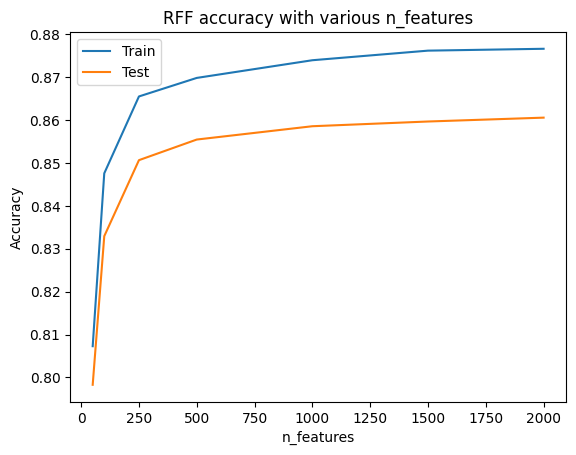

In [33]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

train_acc = []
test_acc = []

n_features_arr = [50, 100, 250, 500, 1000, 1500, 2000]

for n_features in n_features_arr:
    rff = RFFPipeline(n_features=n_features)
    rff.fit(x_train, y_train)

    train_acc.append(accuracy_score(y_train, rff.predict(x_train)))
    test_acc.append(accuracy_score(y_test, rff.predict(x_test)))

clear_output()
plt.plot(n_features_arr, train_acc, label="Train")
plt.plot(n_features_arr, test_acc, label="Test")
plt.title("RFF accuracy with various n_features")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("n_features")
plt.show()

Видно, что на плато модель выходит, после 1000, а минимальное адекватное качество (>0.85) достигается на 250. Скорее всего, там просто мало фичей, мы тут все же картинки классифицируем, 100 фичей - как-то несерьезно. А делать сильно больше исходной - бессмысленно, ничего нового там не будет, на 1000 как будто все возможные частоты косинуса и так переберем

### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

__Задание 5. (Максимум 1 балл)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

__Задание 6. (Максимум 1 балл)__

Реализуйте класс ядровой Ridge регрессии (Лекция 13, $\S 1.2$), для оптимизации используте градиентный спуск, а не аналитическую формулу. Также подумайте о том, как в формулах правильно учесть свободный коэффициент. Затем адаптируйте вашу реализацию RFF под задачу регрессии. Сравните вашу ядровую регрессию и RFF на синтетических данных.

Функция потерь: 
$$
Q(w) = \frac{1}{2} ||\Phi \Phi^T w - y||^2 + \frac{\lambda}{2} w^T \Phi \Phi^T w \rightarrow \min_w,
$$
где $\Phi \Phi^T = K$, $K = (k(x_i, x_j))_{i, j = 1}^{\ell}$.

Предсказание: 
$
y(x) = k(x)^T w,
$
где $k(x)$ — вектор функций ядра от пар объектов $(x, x_i)_{i=1}^{\ell}$.

Вы можете изменять представленный ниже шаблон по своему усмотрению.

In [ ]:
import numpy as np
from sklearn.base import RegressorMixin
from sklearn.gaussian_process.kernels import RBF

class KernelRidgeRegression(RegressorMixin):
    """
    Kernel Ridge regression class
    """

    def __init__(self,         
        lr=0.01,
        regularization=1.,
        tolerance=1e-2,
        max_iter=1000,
        batch_size=64,
        kernel_scale=1.
    ):
        """
        :param lr: learning rate
        :param regularization: regularization coefficient
        :param tolerance: stopping criterion for square of euclidean norm of weight difference
        :param max_iter: stopping criterion for iterations
        :param batch_size: size of the batches used in gradient descent steps
        :parame kernel_scale: length scale in RBF kernel formula
        """

        self.lr: float = lr
        self.regularization: float = regularization
        self.w: np.ndarray | None = None

        self.tolerance: float = tolerance
        self.max_iter: int = max_iter
        self.batch_size: int = batch_size
        self.loss_history: list[float] = []
        self.kernel = RBF(kernel_scale)

    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculating loss for x and y dataset
        :param x: features array
        :param y: targets array
        """
        raise NotImplementedError

    def calc_grad(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculating gradient for x and y dataset
        :param x: features array
        :param y: targets array
        """
        raise NotImplementedError

    def fit(self, x: np.ndarray, y: np.ndarray) -> "KernelRidgeRegression":
        """
        Fitting weights for x and y dataset
        :param x: features array
        :param y: targets array
        :return: self
        """
        raise NotImplementedError

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Predicting targets for x dataset
        :param x: features array
        :return: prediction: np.ndarray
        """
        raise NotImplementedError